<a href="https://colab.research.google.com/github/eduardez/Machine-Learning-ESI/blob/master/Dengue_Task_2_EnsamblerAndOther.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

NOTAS


Testing: coger todos los que tenga a disposicion y hacer con los que hay en la pagina.

Mejor forma: 900 entradas en train de sanjuan -> Pillar 800 y con el resto hacer testing para hacer test en local y luego hacer test gordo.

Mirar el libro que paso manu de KNN y que da la season en funcion de humedad tal y cual, pero los picos no los va a dar nunca porque esos picos tienen relacion con los datos anteriores. Eso se llama tendencia y hay que estudiarlo.

Meterle un random forest. Luego meterle un ensemmbler.


coger el ejemplillo de las bicis y a ver que da, pero lo que mejor resultado va a dar es lo de las tendencias.

QUE DE ENTRE 25 Y 30 

tenemos que predecir el test labeled, pillo el colab del KNN y parto de ahi. 
En el de ejemplo coje 4 features, aplica una funcion que se llama preprocesado. 

En el knn tengo que buscar "shift"  y ponerlo a 0 los periods, el shift coje los valores y los adelanta o los atrasa x semana, porque en el ejemplo dice que es tonteria hacerlo con la lluvia de hoy, tiene que ser con las de hace 2, 3 semanas. 

In [1]:
%matplotlib inline

from __future__ import print_function
from __future__ import division

import pandas as pd
import numpy as np

from matplotlib import pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
import statsmodels.api as sm

# just for the sake of this blog post!
from warnings import filterwarnings
filterwarnings('ignore')


from fbprophet import Prophet

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


#Preparacion

In [2]:
# load the provided data
train_features_raw = pd.read_csv('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_features_train.csv?token=ANLXPWLSBAHLW7JMOAVKME276B3UC',
                             index_col=[0,1,2])

train_labels_raw = pd.read_csv('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_labels_train.csv?token=ANLXPWJ55GZEX4IWHXQA3IS76B3WQ',
                           index_col=[0,1,2])

features_test_raw = pd.read_csv('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_features_test.csv?token=ANLXPWOAY3AS6JWDRSIMHI276CDY6',
                           index_col=[0,1,2])

submission = pd.read_csv('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/submission_format.csv?token=ANLXPWPCMTBVVHBSCUFJB5C76CEHE',
                           index_col=[0,1,2])

In [3]:
train_features = train_features_raw.copy()
train_labels = train_labels_raw.copy()

In [4]:
# Seperate data for San Juan
sj_train_features = train_features.loc['sj']
sj_train_labels = train_labels.loc['sj']

# Separate data for Iquitos
iq_train_features = train_features.loc['iq']
iq_train_labels = train_labels.loc['iq']

In [5]:
print('San Juan')
print('features: ', sj_train_features.shape)
print('labels  : ', sj_train_labels.shape)

print('\nIquitos')
print('features: ', iq_train_features.shape)
print('labels  : ', iq_train_labels.shape)

San Juan
features:  (936, 21)
labels  :  (936, 1)

Iquitos
features:  (520, 21)
labels  :  (520, 1)


In [6]:
# Remove `week_start_date` string.
sj_train_features.drop('week_start_date', axis=1, inplace=True)
iq_train_features.drop('week_start_date', axis=1, inplace=True)

In [7]:
# Null check
print(pd.isnull(sj_train_features).sum())
print('--------------------------------')
print(pd.isnull(iq_train_features).sum())

ndvi_ne                                  191
ndvi_nw                                   49
ndvi_se                                   19
ndvi_sw                                   19
precipitation_amt_mm                       9
reanalysis_air_temp_k                      6
reanalysis_avg_temp_k                      6
reanalysis_dew_point_temp_k                6
reanalysis_max_air_temp_k                  6
reanalysis_min_air_temp_k                  6
reanalysis_precip_amt_kg_per_m2            6
reanalysis_relative_humidity_percent       6
reanalysis_sat_precip_amt_mm               9
reanalysis_specific_humidity_g_per_kg      6
reanalysis_tdtr_k                          6
station_avg_temp_c                         6
station_diur_temp_rng_c                    6
station_max_temp_c                         6
station_min_temp_c                         6
station_precip_mm                          6
dtype: int64
--------------------------------
ndvi_ne                                   3
ndvi_nw   

In [8]:
sj_train_features.fillna(method='ffill', inplace=True)
iq_train_features.fillna(method='ffill', inplace=True)

In [9]:
sj_train_features = sj_train_features.shift(periods = 5, fill_value = 0)
iq_train_features = iq_train_features.shift(periods = 5, fill_value = 0)

In [10]:
sj_train_features

ndvi_ne   ndvi_nw  ...  station_min_temp_c  station_precip_mm
year weekofyear                     ...                                       
1990 18          0.00000  0.000000  ...                 0.0                0.0
     19          0.00000  0.000000  ...                 0.0                0.0
     20          0.00000  0.000000  ...                 0.0                0.0
     21          0.00000  0.000000  ...                 0.0                0.0
     22          0.00000  0.000000  ...                 0.0                0.0
...                  ...       ...  ...                 ...                ...
2008 13         -0.13865 -0.095067  ...                21.7               13.3
     14         -0.13865  0.015420  ...                21.1               12.9
     15         -0.08890 -0.090033  ...                21.1               13.0
     16         -0.32140 -0.141200  ...                22.2                4.4
     17          0.04490  0.024450  ...                20.6                0.5

[936 rows x 20 columns]

In [11]:
sj_train_features['total_cases'] = sj_train_labels.total_cases
iq_train_features['total_cases'] = iq_train_labels.total_cases

In [12]:
# compute the correlations
sj_correlations = sj_train_features.corr()
iq_correlations = iq_train_features.corr()

Text(0.5, 1.0, 'San Juan Variable Correlations')

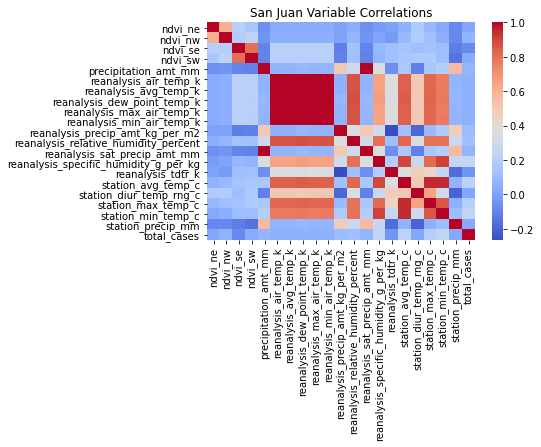

In [13]:
# plot san juan
sj_corr_heat = sns.heatmap(sj_correlations,cmap='coolwarm',xticklabels=True, yticklabels=True)
plt.title('San Juan Variable Correlations')

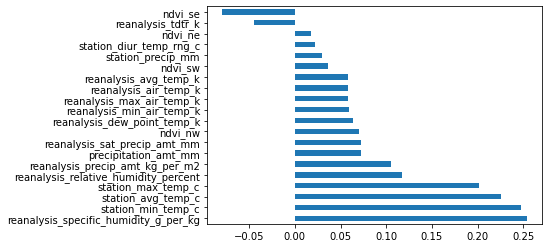

In [14]:
# San Juan
(sj_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())

Text(0.5, 1.0, 'Iquitos Variable Correlations')

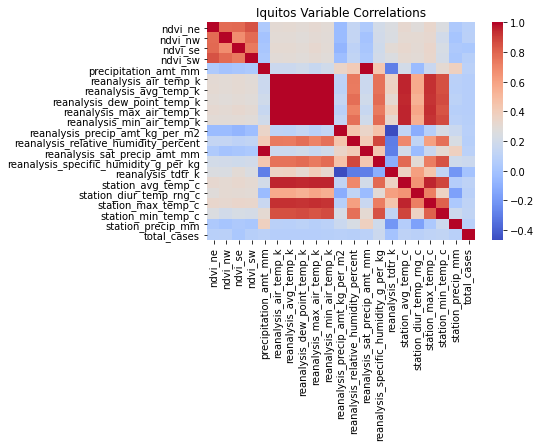

In [15]:
# plot iquitos
iq_corr_heat = sns.heatmap(iq_correlations,cmap='coolwarm',xticklabels=True, yticklabels=True)
plt.title('Iquitos Variable Correlations')

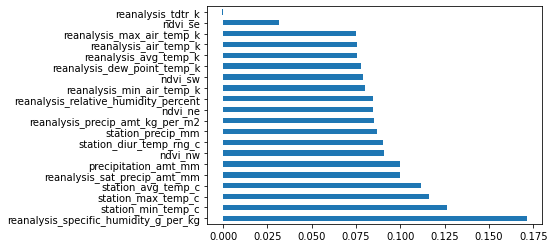

In [16]:
# Iquitos
(iq_correlations
     .total_cases
     .drop('total_cases') # don't compare with myself
     .sort_values(ascending=False)
     .plot
     .barh())

In [17]:
def preprocess_data(data_path, labels_path=None):
    # load data and set index to city, year, weekofyear
    df = pd.read_csv(data_path, index_col=[0, 1, 2])
    
    # select features we want
    features = ['reanalysis_specific_humidity_g_per_kg', 
                 'reanalysis_dew_point_temp_k', 
                 'station_avg_temp_c', 
                 'station_min_temp_c']

    #df = df[features]
    
    # fill missing values
    df.fillna(method='ffill', inplace=True)

    # add labels to dataframe
    if labels_path:
        labels = pd.read_csv(labels_path, index_col=[0, 1, 2])
        df = df.join(labels)
    
    # separate san juan and iquitos
    sj = df.loc['sj']
    iq = df.loc['iq']
    sj = sj.shift(periods = 0, fill_value = 0)
    iq = iq.shift(periods = 0, fill_value = 0)
    return sj, iq

# Empiezo aqui


## Carga de datos

In [18]:
sj_train, iq_train = preprocess_data('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_features_train.csv?token=ANLXPWLSBAHLW7JMOAVKME276B3UC', labels_path="https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_labels_train.csv?token=ANLXPWJ55GZEX4IWHXQA3IS76B3WQ")
sj_test_pred, iq_test_pred = preprocess_data('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_features_test.csv?token=ANLXPWOAY3AS6JWDRSIMHI276CDY6')


selected_features = ['reanalysis_specific_humidity_g_per_kg', 
              'reanalysis_dew_point_temp_k', 
              'station_avg_temp_c', 
              'station_min_temp_c',
              'ndvi_se',
              'ndvi_sw',
              ]



## Division de los sets

In [19]:
sj_train_rf = sj_train.copy()
sj_train_rf.reset_index(drop = True, inplace = True)

iq_train_rf = iq_train.copy()
iq_train_rf.reset_index(drop = True, inplace = True)

In [20]:
sj_train_subtrain = sj_train.head(800)
sj_train_subtest = sj_train.tail(sj_train.shape[0] - 800)

iq_train_subtrain = iq_train.head(400)
iq_train_subtest = iq_train.tail(iq_train.shape[0] - 400)


In [21]:

sj_x_train = sj_train_subtrain[selected_features]
sj_y_train = sj_train_subtrain['total_cases']
sj_x_test = sj_train_subtest[selected_features]
sj_y_test = sj_train_subtest['total_cases']

iq_x_train = iq_train_subtrain[selected_features]
iq_y_train = iq_train_subtrain['total_cases']
iq_x_test = iq_train_subtest[selected_features]
iq_y_test = iq_train_subtest['total_cases']

# Modelos


### Random Forest



In [22]:
no_est = 1000
mx_dpth = 5
crit = 'mae'
rndm_state = 0

sj_regressor = RandomForestRegressor(n_estimators= no_est, max_depth = mx_dpth, criterion=crit, random_state=rndm_state)
sj_regressor.fit(sj_x_train, sj_y_train)


iq_regressor = RandomForestRegressor(n_estimators= no_est, max_depth = mx_dpth, criterion=crit, random_state=rndm_state)
iq_regressor.fit(iq_x_train, iq_y_train)



RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mae',
                      max_depth=5, max_features='auto', max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=1000, n_jobs=None, oob_score=False,
                      random_state=0, verbose=0, warm_start=False)

In [23]:
sj_prediction = sj_regressor.predict(sj_test_pred[selected_features])
iq_prediction = iq_regressor.predict(iq_test_pred[selected_features])


### DecisionTree


In [31]:
from sklearn.tree import DecisionTreeRegressor

mx_dpth = 4
crit = 'mae'

sj_regressor_dt = DecisionTreeRegressor(max_depth = mx_dpth, criterion=crit)
sj_regressor_dt.fit(sj_x_train, sj_y_train)


iq_regressor_dt = DecisionTreeRegressor(max_depth = mx_dpth, criterion=crit)
iq_regressor_dt.fit(iq_x_train, iq_y_train)



DecisionTreeRegressor(ccp_alpha=0.0, criterion='mae', max_depth=4,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [32]:
sj_prediction = sj_regressor_dt.predict(sj_test_pred[selected_features])
iq_prediction = iq_regressor_dt.predict(iq_test_pred[selected_features])

### Ensamble

In [ ]:
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor

# Fit regression model
regressors = []
regressors.append(DecisionTreeRegressor(max_depth=4, criterion='mae'))
# http://scikit-learn.org/stable/auto_examples/ensemble/plot_adaboost_regression.html#
regressors.append(AdaBoostRegressor(DecisionTreeRegressor(max_depth=4, criterion='mae'),
                          n_estimators=300, random_state=rng))
#http://scikit-learn.org/stable/auto_examples/ensemble/plot_gradient_boosting_regression.html#sphx-glr-auto-examples-ensemble-plot-gradient-boosting-regression-py                         
regressors.append(GradientBoostingRegressor(n_estimators=100, learning_rate=0.1,
                                   max_depth=4, random_state=0, loss='ls'))

# Prophet


In [24]:
df_train = pd.read_csv('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_features_train.csv?token=ANLXPWLSBAHLW7JMOAVKME276B3UC')
df_test = pd.read_csv('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_features_test.csv?token=ANLXPWOAY3AS6JWDRSIMHI276CDY6')
df_labels = pd.read_csv('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/dengue_labels_train.csv?token=ANLXPWJ55GZEX4IWHXQA3IS76B3WQ')


In [26]:
df_train['total_cases'] = df_labels['total_cases']
prophet_data = df_train[['city', 'week_start_date', 'total_cases']]

prophet_data_sj = prophet_data[prophet_data['city'] == 'sj'].drop('city', axis=1)
prophet_data_iq = prophet_data[prophet_data['city'] == 'iq'].drop('city', axis=1)

test_sj = df_test[df_test['city'] == 'sj']['week_start_date']
test_iq = df_test[df_test['city'] == 'iq']['week_start_date']

# prophet_data_sj = prophet_data_sj.shift(periods = 5, fill_value = 0)
# prophet_data_iq = prophet_data_iq.shift(periods = 3, fill_value = 0)

In [27]:
prophet_data_sj.columns, prophet_data_iq.columns = ['ds', 'y'], ['ds', 'y']

In [28]:
def create_forecast(train_data, test_data, flex, seas):
    
    prophet = Prophet(changepoint_prior_scale=flex, 
                      yearly_seasonality=seas) 
    
    prophet.fit(train_data)
    
    future_frame = prophet.make_future_dataframe(
        periods=len(test_data), 
        freq='W')
    
    forecast = prophet.predict(future_frame)
    
    prophet.plot(forecast)
    
    forecast = forecast[['ds', 'yhat']].yhat.apply(lambda x : int(x))
    return forecast[len(train_data):]

INFO:numexpr.utils:NumExpr defaulting to 2 threads.
INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


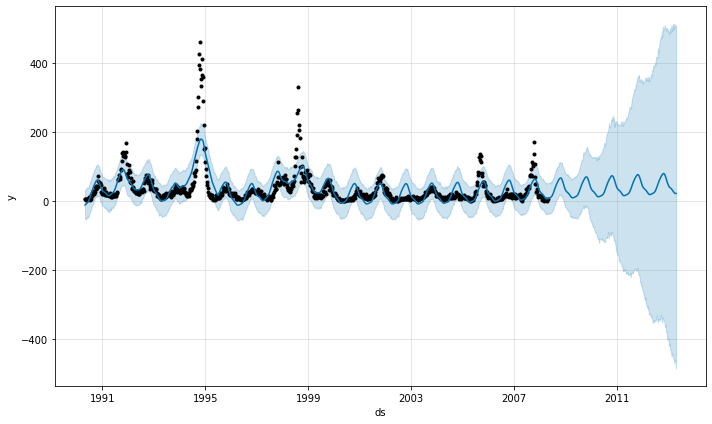

In [29]:
sj_prediction_rf_int = create_forecast(prophet_data_sj, test_sj, 0.3, 4)


INFO:fbprophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


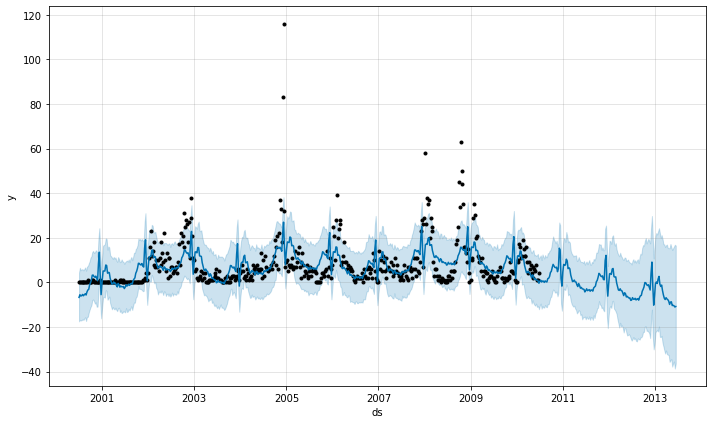

In [30]:
iq_prediction_rf_int = create_forecast(prophet_data_iq, test_iq, 0.30, 20)

### MAE & Plotting

In [46]:
### ------------- SELECCIONAR AQUI EL MODELO PARA EL MAE -------------
sj_prediction_test = sj_regressor_dt.predict(sj_x_test)
iq_prediction_test = iq_regressor_dt.predict(iq_x_test)

In [47]:
from sklearn.metrics import mean_absolute_error


sj_mae = mean_absolute_error(sj_y_test,sj_prediction_test)
iq_mae = mean_absolute_error(iq_y_test,iq_prediction_test)

print ("Error Measure --> IQ: {}, SJ: {} ".format(iq_mae, sj_mae))

Error Measure --> IQ: 6.8875, SJ: 21.897058823529413 


(-5.95, 124.95, -3.1500000000000004, 66.15)

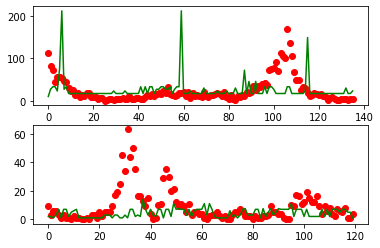

In [50]:
figs, axes = plt.subplots(nrows=2, ncols=1)
# x axis for plotting
import matplotlib.pyplot as plt
import numpy as np

sj_xx = np.stack(i for i in range(len(sj_y_test)))
axes[0].scatter(sj_xx, sj_y_test, c='r', label='data')
axes[0].plot(sj_xx, sj_prediction_test, c='g', label='prediction')
axes[0].axis('tight')

iq_xx = np.stack(i for i in range(len(iq_y_test)))
axes[1].scatter(iq_xx, iq_y_test, c='r', label='data')
axes[1].plot(iq_xx, iq_prediction_test, c='g', label='prediction')
axes[1].axis('tight')



In [51]:
# FEATURE RELEVANCIES
print ('Feature Relevancies')
pd.DataFrame({'Attributes': selected_features ,
              'Decision Tree': sj_regressor.feature_importances_})

Feature Relevancies


,Attributes,Decision Tree
0,reanalysis_specific_humidity_g_per_kg,0.172504
1,reanalysis_dew_point_temp_k,0.117548
2,station_avg_temp_c,0.119405
3,station_min_temp_c,0.048364
4,ndvi_se,0.279328
5,ndvi_sw,0.262851


# Predict values

In [52]:
submission = pd.read_csv('https://raw.githubusercontent.com/eduardez/Machine-Learning-ESI/master/submission_format.csv?token=ANLXPWPCMTBVVHBSCUFJB5C76CEHE',index_col=[0,1,2])

In [53]:
sj_prediction_rf_int = np.rint(sj_prediction) # round
sj_prediction_rf_int = sj_prediction_rf_int.astype(int) # cast to int


In [54]:
iq_prediction_rf_int = np.rint(iq_prediction) # round
iq_prediction_rf_int = iq_prediction_rf_int.astype(int) # cast to int

In [55]:
submission.total_cases = np.concatenate([sj_prediction_rf_int, iq_prediction_rf_int])
submission

total_cases
city year weekofyear             
sj   2008 18                   17
          19                   23
          20                   17
          21                   17
          22                   23
...                           ...
iq   2013 22                    1
          23                    1
          24                    1
          25                    1
          26                    1

[416 rows x 1 columns]

In [133]:


from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

submission.to_csv("benchmark.csv")

Mounted at /content/gdrive
